## License 

Copyright 2017 Patrick Hall (phall@h2o.ai) and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

#### Python imports 

In [1]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
import xgboost as xgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# h2o
import h2o
h2o.init()

# this LIME package
from lime_xgboost import * 

# enables display of plots in notebook
%matplotlib inline              

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpars6k5qk
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpars6k5qk/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpars6k5qk/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,2 months and 19 days
H2O cluster name:,H2O_from_python_phall_wx3pdu
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Import data and clean

In [2]:
# import XLS file
path = '../data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Split data into training and test sets for early stopping

In [4]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier

In [5]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress


[0]	train-auc:0.867607	eval-auc:0.719086
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.908766	eval-auc:0.743725
[2]	train-auc:0.920756	eval-auc:0.752839
[3]	train-auc:0.930517	eval-auc:0.756456
[4]	train-auc:0.937103	eval-auc:0.760017
[5]	train-auc:0.945061	eval-auc:0.76287
[6]	train-auc:0.950831	eval-auc:0.764268
[7]	train-auc:0.955773	eval-auc:0.764722
[8]	train-auc:0.95959	eval-auc:0.766275
[9]	train-auc:0.962581	eval-auc:0.766719
[10]	train-auc:0.966681	eval-auc:0.76766
[11]	train-auc:0.9689	eval-auc:0.767918
[12]	train-auc:0.971268	eval-auc:0.76883
[13]	train-auc:0.972708	eval-auc:0.768897
[14]	train-auc:0.974436	eval-auc:0.768584
[15]	train-auc:0.975561	eval-auc:0.768735
[16]	train-auc:0.977073	eval-auc:0.768516
[17]	train-auc:0.977979	eval-auc:0.769351
[18]	train-auc:0.979268	eval-auc:0.769351
[19]	train-auc:0.980756	eval-auc:0.770029
[20]	train-auc:0.982185	eval-auc:0.

####  Display variable importance

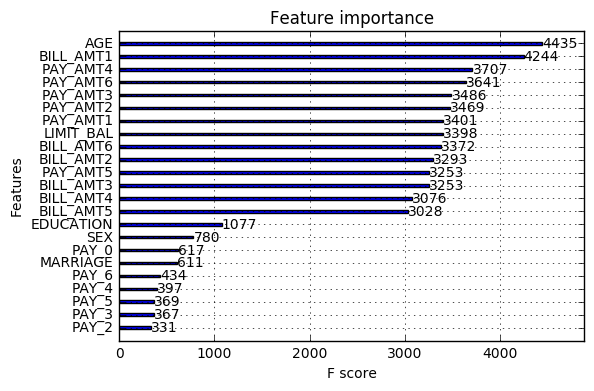

In [6]:
# plot variable importance bar chart
_ = xgb.plot_importance(xgb_model)

#### Explain a prediction with LIME


Local GLM R-square: 0.72
        Input  Local Contribution
0   LIMIT_BAL           -0.049329
1         SEX           -0.045715
2         AGE           -0.038814
3   EDUCATION           -0.021997
4    MARRIAGE           -0.014880
5    PAY_AMT3           -0.002640
6    PAY_AMT1           -0.002285
7    PAY_AMT2           -0.001694
8   BILL_AMT1           -0.001084
9   BILL_AMT4           -0.000964
10   PAY_AMT4           -0.000932
11  BILL_AMT2           -0.000645
12  BILL_AMT3           -0.000637
13  BILL_AMT5           -0.000318
14   PAY_AMT5           -0.000141
15  BILL_AMT6           -0.000041
16      PAY_3            0.010590
17      PAY_6            0.010630
18      PAY_2            0.010704
19      PAY_4            0.010729
20      PAY_5            0.010984
21      PAY_0            0.012478


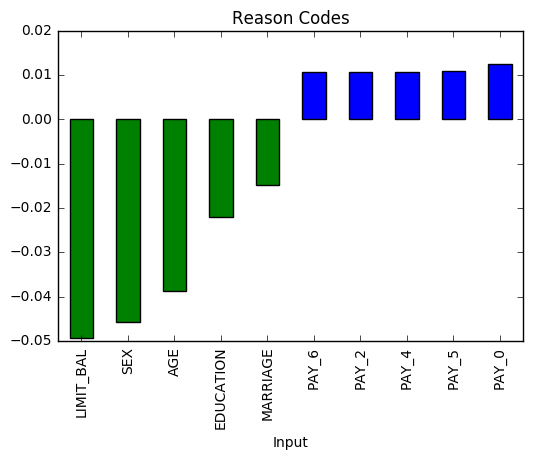

In [7]:
row_id = 20
explainer = LIMEExplainer(training_frame=test, X=X, model=xgb_model, discretize=False)
explainer.explain(row_id)